**Review**

Hi, my name is Dmitry and I will be reviewing your code.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall! I added some suggestions for improvements below, but the code can be accepted now. Based on your final model's ROC-AUC you've got 6 SP. Congratulations! :)

<div class="alert alert-success">
    Hi Johannah! I have approved your initial report for the final project. Great work! Just wanted to add some helpful pointers:
    <br/><br/>
If end date is empty, assume that the customer is still with the company (no churn)
    <br/><br/>
    When merging dataframes make sure that you do not miss any customers since some ID’s may not exist in certain tables. You can treat these missing cases as that customer not signing up for the specific service
<br/><br/>
    Your target variable should be Churn / No Churn, this will be a binary classification task
<br/><br/>
    Make sure that the validation set is used to tune hyperparameters, good idea to use gridsearch
<br/><br/>
    There does indeed exist a class imbalance in the data, make sure this is accounted for
<br/><br/>
    Careful with data leakage, make sure to not include features that may be collinear (i.e if using one-hot encoding for categorical variables, drop one of the columns) or reference the target variable in some way (see topic on data leakage)
<br/><br/>
    Some models you can try are logistic regression, random forest, gradient boosting algorithms like catboost
<br/><br/>
    Very good EDA plan
<br/><br/>
    The goal of this project is to understand why customers churned or stopped their service. And we can use machine learning to identify features of the data that had high predictive power when determining which customers will churn. And if we know that, what can we do as a company to prevent ongoing churn (this part is more of a discussion question for your end
<br/><br/>
-Yervand, Data Science Tutor
</div>

# Telecom Churn Prediction
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

In [1]:
import pandas as pd
import time
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None # to avoid SettingWithCopyWarning after scaling


from sklearn.dummy import DummyClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier 
from xgboost import XGBClassifier 


from sklearn import metrics
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# import warnings
import warnings
warnings.filterwarnings('ignore')

# import sklearn utilities
from sklearn.utils import shuffle


In [2]:
contracts_df= pd.read_csv('/datasets/final_provider/contract.csv')
personal_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
def draw_general_info(data):
    """Takes dataframe and draws the main staistics
    and information about the data in one table.
    """
    df = pd.DataFrame()
    df["missing"] = data.isna().sum().sort_values(ascending=False)
    df["%_missing"] = (data.isna().sum() / data.isna().count()).sort_values(
        ascending=False
    )
    df["%_missing"] = pd.Series(
        ["{:.3%}".format(x) for x in df["%_missing"]], index=df.index
    )
    df["value_sample"] = data.sample().T
    df["dtype"] = data.dtypes
    describe = data.describe(include="all").round(3).T
    df = df.merge(describe, left_on=df.index, right_on=describe.index)
    df["count"] = df["count"].astype(int)
    df.rename({"key_0":"column_name"}, inplace=True, axis=1)
    df["unique"] = pd.Series(
        [data[column].nunique() for column in df["column_name"]], index=df.index
    )
    df.fillna("", inplace=True)
    display(df)


In [4]:
draw_general_info(contracts_df)

,column_name,missing,%_missing,value_sample,dtype,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,customerID,0,0.000%,5103-MHMHY,object,7043,7043,5996-DAOQL,1,,,,,,,
1,BeginDate,0,0.000%,2019-12-01,object,7043,77,2014-02-01,366,,,,,,,
2,EndDate,0,0.000%,2020-01-01 00:00:00,object,7043,5,No,5174,,,,,,,
3,Type,0,0.000%,Month-to-month,object,7043,3,Month-to-month,3875,,,,,,,
4,PaperlessBilling,0,0.000%,No,object,7043,2,Yes,4171,,,,,,,
5,PaymentMethod,0,0.000%,Mailed check,object,7043,4,Electronic check,2365,,,,,,,
6,MonthlyCharges,0,0.000%,45.95,float64,7043,1585,,,64.762,30.09,18.25,35.5,70.35,89.85,118.75
7,TotalCharges,0,0.000%,45.95,object,7043,6531,20.2,11,,,,,,,


In [5]:
contracts_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
draw_general_info(personal_df)

,column_name,missing,%_missing,value_sample,dtype,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,customerID,0,0.000%,6356-ELRKD,object,7043,7043,5996-DAOQL,1,,,,,,,
1,gender,0,0.000%,Female,object,7043,2,Male,3555,,,,,,,
2,SeniorCitizen,0,0.000%,0,int64,7043,2,,,0.162,0.369,0.0,0.0,0.0,0.0,1.0
3,Partner,0,0.000%,No,object,7043,2,No,3641,,,,,,,
4,Dependents,0,0.000%,No,object,7043,2,No,4933,,,,,,,


In [7]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
draw_general_info(internet_df)

,column_name,missing,%_missing,value_sample,dtype,count,unique,top,freq
0,customerID,0,0.000%,5855-EIBDE,object,5517,5517,1767-TGTKO,1
1,InternetService,0,0.000%,Fiber optic,object,5517,2,Fiber optic,3096
2,OnlineSecurity,0,0.000%,Yes,object,5517,2,No,3498
3,OnlineBackup,0,0.000%,Yes,object,5517,2,No,3088
4,DeviceProtection,0,0.000%,Yes,object,5517,2,No,3095
5,TechSupport,0,0.000%,Yes,object,5517,2,No,3473
6,StreamingTV,0,0.000%,No,object,5517,2,No,2810
7,StreamingMovies,0,0.000%,Yes,object,5517,2,No,2785


In [9]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
draw_general_info(phone_df)

,column_name,missing,%_missing,value_sample,dtype,count,unique,top,freq
0,customerID,0,0.000%,7416-CKTEP,object,6361,6361,5996-DAOQL,1
1,MultipleLines,0,0.000%,No,object,6361,2,No,3390


In [11]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## Data Overview

Our client telecom has tasked me with creating a model which can predict customer churn. 

Here are my initial notes on the data:
 
 - There are no missing values in this database
 - column names need to be changed to snakecase
 - Yes and No, male and female, dsl or fiberoptic, columns will be changed to binary: 1 or 0
 - begin date and end date should be changed to datetime data type
 
## Project Plan

1. Clean up the data as described above
2. Merge the 4 dataframes across the Customer ID column 
3. Explore data in depth using EDA
4. Use one hot encoding to engineer features. 
    - create a 'churned' column from the end date column, 1 for yes, 0 for no
    - use one hot encoding on paymentmethod, type, and paperless billing
5. Perform class balancing if discovered to be necessary in EDA
6. Scale the data as necessary if indicated by EDA
7. Drop non vital features
8. Split the data into the train test and validation sets
    - The target will be the engineered churn column
9. Train the models and test them on the validation sets
10. Tune models using the hyperparameters
11. Choose the best scoring model and perform final test with the test set 
12. Write up the final conclusions 

I will be  using AUC_ROC and accuracy scores to test the models aptitude. 

## Data preprocessing  

In [12]:
# joining datasets 
merged_df = pd.merge(contracts_df, internet_df, on="customerID", how='left')
merged_df1 = pd.merge(merged_df, personal_df, on="customerID", how='left')
merged_df2 = pd.merge(merged_df1, phone_df, on="customerID", how='left')
merged_df2 = merged_df2.fillna('No')
merged_df2.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
2061,4958-GZWIY,2019-04-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,48.70,340.25,DSL,No,No,Yes,No,No,No,Male,0,Yes,Yes,No
2052,2038-LLMLM,2016-02-01,No,Month-to-month,Yes,Electronic check,103.85,4946.05,Fiber optic,No,No,Yes,Yes,Yes,Yes,Female,0,No,No,Yes
6081,8757-TFHHJ,2020-01-01,No,Month-to-month,Yes,Credit card (automatic),49.80,49.8,DSL,Yes,No,No,No,No,No,Male,0,No,No,No
2927,5542-TBBWB,2020-01-01,No,Month-to-month,Yes,Electronic check,69.90,69.9,Fiber optic,No,No,No,No,No,No,Male,0,No,No,No
3081,6376-GAHQE,2019-07-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,77.85,299.2,Fiber optic,No,No,No,No,Yes,No,Male,0,No,No,No


In [13]:
df=merged_df2.copy()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [15]:
#Changing the column names to snake_case

df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.replace("[ ]", "_", regex=True)


In [16]:
df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [17]:
df= df.rename(columns={'customerid' : 'customer_id',
                   'begindate' : 'begin_date',
                   'enddate' : 'end_date',
                   'paperlessbilling' : 'paperless_billing',
                   'paymentmethod' : 'payment_method',
                   'monthlycharges' : 'monthly_charges',
                   'totalcharges' : 'total_charges',
                   'seniorcitizen' : 'senior_citizen',
                   'internetservice' : 'internet_service',
                   'onlinesecurity' : 'online_security',
                   'onlinebackup' : 'online_backup',
                   'deviceprotection' : 'device_protection',
                   'techsupport' : 'tech_support',
                   'streamingtv' : 'streaming_tv',
                   'streamingmovies' : 'streaming_movies',
                   'multiplelines' : 'multiple_lines'}
         )

In [18]:
df.gender.replace(('Male', 'Female'), (1, 0), inplace=True)

In [19]:
df.internet_service.replace(('DSL', 'Fiber optic'), (1, 0), inplace=True)

In [20]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,No,Yes,No,No,No,No,0,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1,Yes,No,Yes,No,No,No,1,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,No,No,No,No,1,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,Yes,No,Yes,Yes,No,No,1,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,0,No,No,No,No,No,No,0,0,No,No,No


In [21]:
#df.replace(('Yes', 'No'), (1, 0), inplace=True)

In [22]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1,No,Yes,No,No,No,No,0,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1,Yes,No,Yes,No,No,No,1,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Yes,Yes,No,No,No,No,1,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,1,Yes,No,Yes,Yes,No,No,1,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,0,No,No,No,No,No,No,0,0,No,No,No


In [23]:
df.describe()

,monthly_charges,gender,senior_citizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,0.504756,0.162147
std,30.090047,0.500013,0.368612
min,18.250000,0.000000,0.000000
25%,35.500000,0.000000,0.000000
50%,70.350000,1.000000,0.000000
75%,89.850000,1.000000,0.000000
max,118.750000,1.000000,1.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  gender             7043 non-null   int64  
 16  senior_citizen     7043 

In [25]:
def change_datatype(df, cols, type_val):
    for col in cols:
        df[col] = df[col].astype(type_val)

# create new end date feature
list_value = []
for value in df.end_date:
    if value != 'No':
        datetime_value = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')
        list_value.append(datetime_value)
    else:
        contract_valid_date = '2020-02-01 00:00:00' # date contract is valid
        contract_valid_date_value = datetime.strptime(contract_valid_date, '%Y-%m-%d %H:%M:%S')
        list_value.append(contract_valid_date_value)
EndDate_value = pd.to_datetime(list_value)
df.insert(3, 'end_date_value', EndDate_value)

# prepare TotalChargers 
df.loc[df['total_charges'].isin([' ']),'total_charges'] = 0

# change datatypes
change_datatype(df, ['begin_date'], 'datetime64[ns]')
change_datatype(df, ['monthly_charges', 'total_charges'], 'float32')
change_datatype(df, ['senior_citizen'], 'int32')

In [26]:
#changing the data types
df['begin_date'] = pd.to_datetime(df['begin_date'],format='%Y%m%d', errors='ignore')

In [27]:
df['end_date'] = pd.to_datetime(df['end_date'],format='%Y%m%d', errors='ignore')

In [28]:
df.loc[df['total_charges'].isin([' ']),'total_charges'] = 0

In [29]:
df['total_charges'] = df['total_charges'].astype('float')

In [30]:
df['senior_citizen'] = df['senior_citizen'].astype('int64')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   end_date_value     7043 non-null   datetime64[ns]
 4   type               7043 non-null   object        
 5   paperless_billing  7043 non-null   object        
 6   payment_method     7043 non-null   object        
 7   monthly_charges    7043 non-null   float32       
 8   total_charges      7043 non-null   float64       
 9   internet_service   7043 non-null   object        
 10  online_security    7043 non-null   object        
 11  online_backup      7043 non-null   object        
 12  device_protection  7043 non-null   object        
 13  tech_support       7043 non-null   object        
 14  streamin

In [32]:
df.head()

,customer_id,begin_date,end_date,end_date_value,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,2020-02-01,Month-to-month,Yes,Electronic check,29.850000,29.850000,1,...,Yes,No,No,No,No,0,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,2020-02-01,One year,No,Mailed check,56.950001,1889.500000,1,...,No,Yes,No,No,No,1,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,Month-to-month,Yes,Mailed check,53.849998,108.150002,1,...,Yes,No,No,No,No,1,0,No,No,No
3,7795-CFOCW,2016-05-01,No,2020-02-01,One year,No,Bank transfer (automatic),42.299999,1840.750000,1,...,No,Yes,Yes,No,No,1,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,Month-to-month,Yes,Electronic check,70.699997,151.649994,0,...,No,No,No,No,No,0,0,No,No,No


## Feature Engineering 
I will engineer features for length of service as 'tenure', a binary column for if a customer has churned or not as 'churned', a column for the number of services a person is using, a binary column for if a person has a credit card on file as 'has_card', and columns for the 'year', 'month', and 'dayofweek' the customer joined telecom 

In [33]:
# change date type to datetime and split into day, month and year
def new_date_features(df):
    columns = df.columns.tolist()
    idx = [columns.index(x) for x in columns if 'begin_date' in x][0]
    
    df[columns[idx]] = pd.to_datetime(df[columns[idx]])
    df['dayofweek'] = df[columns[idx]].dt.day_name()
    df['month'] = df[columns[idx]].dt.month_name()
    df['year'] = df[columns[idx]].dt.year
    return df; 

In [34]:
new_date_features(df)
df['tenure'] = df['end_date_value'].dt.year - df['begin_date'].dt.year
df['has_crcard'] = [1 if x == 'Credit card (automatic)' else 0 for x in df['payment_method']]
df['exited'] = [1 if x != 'No' else 0 for x in df['end_date']]
df['service_count'] = [x.count('Yes') for x in zip(df['online_security'], df['online_backup'], df['device_protection'], 
                                                           df['tech_support'], df['streaming_tv'], df['streaming_movies'])]


In [35]:
df.head(20)

,customer_id,begin_date,end_date,end_date_value,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,partner,dependents,multiple_lines,dayofweek,month,year,tenure,has_crcard,exited,service_count
0,7590-VHVEG,2020-01-01,No,2020-02-01,Month-to-month,Yes,Electronic check,29.850000,29.850000,1,...,Yes,No,No,Wednesday,January,2020,0,0,0,1
1,5575-GNVDE,2017-04-01,No,2020-02-01,One year,No,Mailed check,56.950001,1889.500000,1,...,No,No,No,Saturday,April,2017,3,0,0,2
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,2019-12-01,Month-to-month,Yes,Mailed check,53.849998,108.150002,1,...,No,No,No,Tuesday,October,2019,0,0,1,2
3,7795-CFOCW,2016-05-01,No,2020-02-01,One year,No,Bank transfer (automatic),42.299999,1840.750000,1,...,No,No,No,Sunday,May,2016,4,0,0,3
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,2019-11-01,Month-to-month,Yes,Electronic check,70.699997,151.649994,0,...,No,No,No,Sunday,September,2019,0,0,1,0
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,2019-11-01,Month-to-month,Yes,Electronic check,99.650002,820.500000,0,...,No,No,Yes,Friday,March,2019,0,0,1,3
6,1452-KIOVK,2018-04-01,No,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,0,...,No,Yes,Yes,Sunday,April,2018,2,1,0,2
7,6713-OKOMC,2019-04-01,No,2020-02-01,Month-to-month,No,Mailed check,29.750000,301.899994,1,...,No,No,No,Monday,April,2019,1,0,0,1
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,2019-11-01,Month-to-month,Yes,Electronic check,104.800003,3046.050049,0,...,Yes,No,Yes,Saturday,July,2017,2,0,1,4
9,6388-TABGU,2014-12-01,No,2020-02-01,One year,No,Bank transfer (automatic),56.150002,3487.949951,1,...,No,Yes,No,Monday,December,2014,6,0,0,2


## EDA 

In [36]:
def plot_snsbar(df, x, y, title):
    xlabel = str(x.replace('_', ' ').capitalize())
    ylabel = str(y.replace('_', ' ').capitalize())
    # create grouped data
    data = df.groupby([x])[y].count().sort_values(ascending=False).reset_index()
    fig, ax=plt.subplots(figsize=(10,6))
    ax = sns.barplot(x = x, y = y, data=data)
    ax.set_title(title, fontdict={'size':12})
    ax.set_ylabel(ylabel, fontsize = 10)
    ax.set_xlabel(xlabel, fontsize = 10)
    ax.set_xticklabels(data[x], rotation=90);

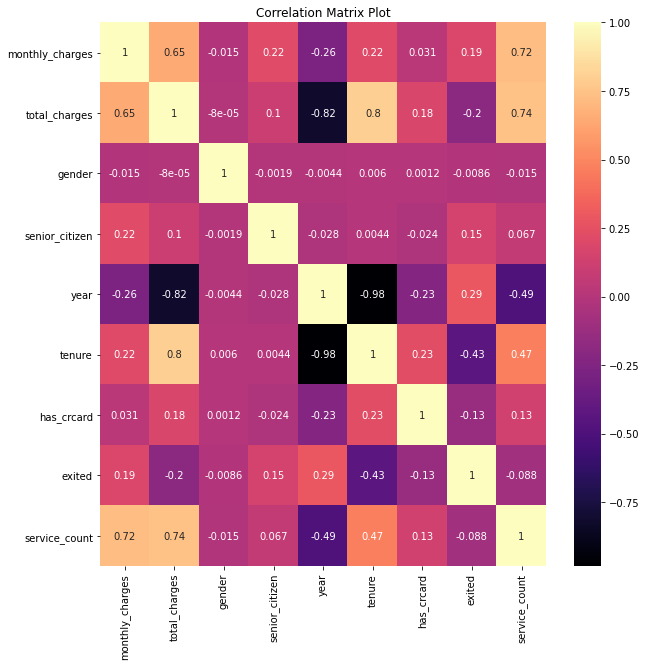

In [37]:
# correlation matrix of features
plt.figure(figsize=(10, 10))
corrMatrix = df.corr()
sns.color_palette("magma", as_cmap=True)
sns.heatmap(corrMatrix, annot=True, cmap='magma')
plt.title('Correlation Matrix Plot')
plt.show();

First I will explore a relationship between contract type and revenue 

In [38]:
# total monthly charges grouped by payment type
(df.groupby('type', as_index=False)
     .agg({'monthly_charges': 'sum', 'total_charges': 'sum'})
     .sort_values(by='total_charges', ascending=False, ignore_index=True)
)

,type,monthly_charges,total_charges
0,Two year,103005.851562,6.283254e+06
1,Month-to-month,257294.156250,5.305862e+06
2,One year,95816.601562,4.467054e+06


here we can see that though month-to-month contracts bring in the most revenue monthly, two year contracts actually bring in the most revenue

In [39]:
# services count grouped by contract type
(df.groupby('type', as_index=False)
     .agg({'service_count': 'sum'})
     .sort_values(by='service_count', ascending=False, ignore_index=True)
)

,type,service_count
0,Month-to-month,6013
1,Two year,4654
2,One year,3686


Checking if there is an emphasis on churn by contract type

In [40]:
# effect of contract type on customer churn
contract_type_percent = df.groupby(
    'type', as_index=False).agg(
    {'exited': 'sum'}).sort_values(
    by='exited', ascending=False, ignore_index=True)
contract_type_effect = (df['type'].value_counts() / df['type'].value_counts().sum() * 100).tolist()
contract_type_percent['% exit percent'] = ['{:.2f}'.format(x) for x in contract_type_effect]
contract_type_percent

,type,exited,% exit percent
0,Month-to-month,1655,55.02
1,One year,166,24.07
2,Two year,48,20.91


we can see there is a much higher percentage of churned accounts in the month to month contract type and the two year contract type has the lowest churn percentage. 

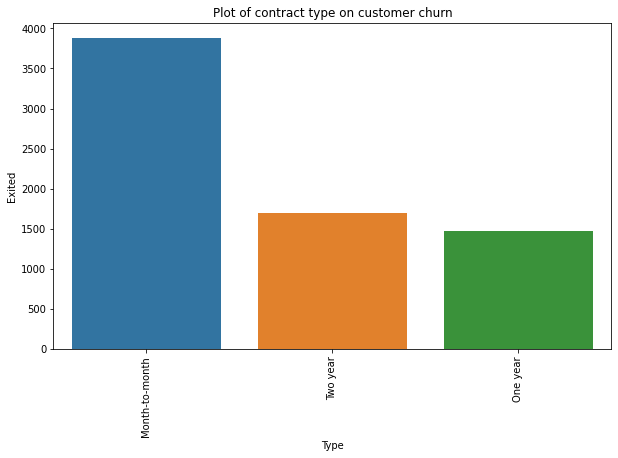

In [41]:
# plot of contract type on customer churn
plot_snsbar(df, 'type', 'exited', 'Plot of contract type on customer churn')


month to month contracts churn more often than the other two contracts


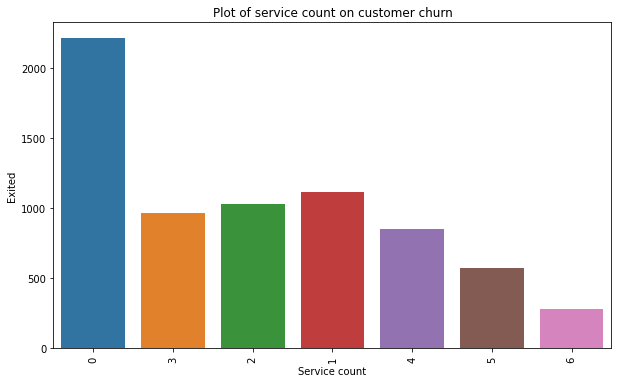

In [42]:
# plot of service count on customer churn
plot_snsbar(df, 'service_count', 'exited', 'Plot of service count on customer churn')

customers with 5 or more services are less likely to churn



### What are the top services patronized?


In [43]:
# we create a copy of the dataframe to use for encoding
df_encode = df.copy()

# encoding services offered 
online_security = {'online_security':{'Yes': 1, 'No': 0}}
online_backup = {'online_backup':{'Yes': 1, 'No': 0}}
device_protection = {'device_protection':{'Yes': 1, 'No': 0}}
tech_support = {'tech_support':{'Yes': 1, 'No': 0}}
streaming_tv = {'streaming_tv':{'Yes': 1, 'No': 0}}
streaming_movies = {'streaming_movies':{'Yes': 1, 'No': 0}}

df_encode.replace(online_security, inplace =True)
df_encode.replace(online_backup, inplace =True)
df_encode.replace(device_protection, inplace =True)
df_encode.replace(tech_support, inplace =True)
df_encode.replace(streaming_tv, inplace =True)
df_encode.replace(streaming_movies, inplace =True)

services_data = df_encode[['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'exited']]
services_data = services_data.transpose()
services_data

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
online_security,0,1,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,1
online_backup,1,0,1,0,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0
device_protection,0,1,0,1,0,1,0,0,1,0,...,0,1,0,1,0,1,1,0,0,1
tech_support,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
streaming_tv,0,0,0,0,0,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,1
streaming_movies,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,1,0,0,1
exited,0,0,1,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [44]:
# getting dataframe showing services and percentage count 
services_data['count'] = services_data.sum(axis=1)
services_df = services_data.reset_index(inplace=False)
services_df = services_df[['index', 'count']].rename(columns={'index': 'services'})
services_df['% service offered']  = services_df['count'] / services_df['count'].sum() * 100
services = services_df.copy()
services.sort_values('% service offered', axis = 0, ascending = False, inplace = True, ignore_index=True)
services

,services,count,% service offered
0,streaming_movies,2732,16.841327
1,streaming_tv,2707,16.687215
2,online_backup,2429,14.973493
3,device_protection,2422,14.930342
4,tech_support,2044,12.600173
5,online_security,2019,12.446061
6,exited,1869,11.521391


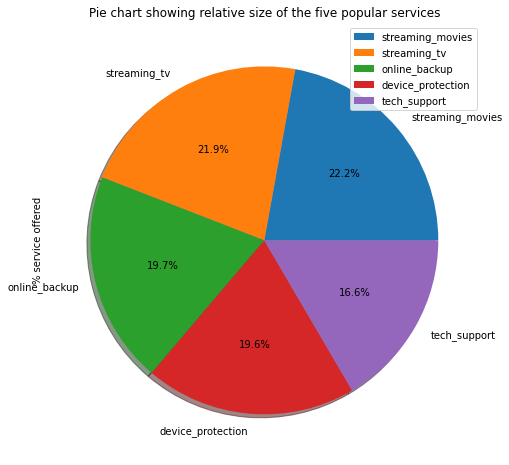

In [45]:
# plot of top 5 Interconnect service by count 
services_pie = services.head(5)
(services_pie.set_index('services').plot(y='% service offered', kind='pie', 
                      title = 'Pie chart showing relative size of the five popular services', 
                      figsize=(8, 8), autopct='%1.1f%%', shadow=True)
);

The distribution of services patronized appears to be fairly even.

### When do customers churn?

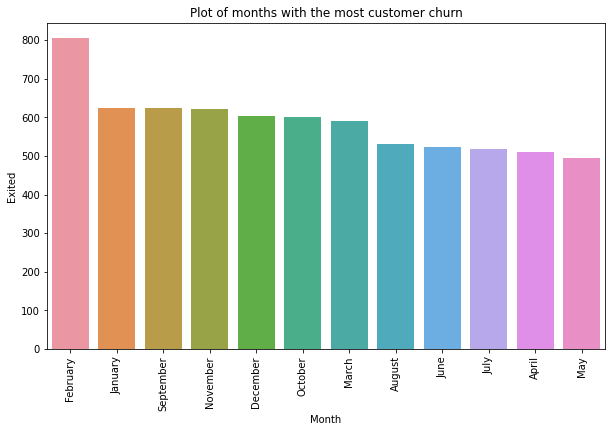

In [46]:
# plot to determine months with the most churn
plot_snsbar(df, 'month', 'exited', 'Plot of months with the most customer churn')

I would recommend that based on this graph, indicating high churn months to be February, September and December, that Telecom start incentive campagns in the months prior to these high churn months in an effort to reduce churn. For example in November January telecom could begin offering a free additional service (like movie streaming, or 'buyers choice') for a period of time to ward off some churn.

### EDA Conclusions
From the exploratory data analasis we were able to learn the following:
- Most customers prefer the month-to- month plan, with a majority of 61% of the customer base chosing this option
- Customers with a 2 year contract are bringing in more revenue than the other two contract options 
- Customers on a 2 year contract are churning less than the other contracts
- customers having 5 or more services with telecom are less likely to churn
Recommendations:
- incentivize 2 year contract participation, one month free, get two services for the price of one for the first year etc.
- boost multiple service use by using promotions 
- introduce bonuses and incentives before peak churn months 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job on data preprocessing and EDA! Dataframes were merged correctly. Tenure is a great feature!

</div>

## Modeling 

In order to design the best model to predict customer churn I will train several models on the data and see which scores the highest on the AUC-ROC metric as well as check their accuracy. 
I will test:
- dummy classifier
- logistic regression
- random forest classifier
- Cat Boost
- LightGBM

#### Splitting the data

In [47]:
# drop unimportant features
df = df.drop(['customer_id', 'begin_date', 'end_date', 'end_date_value', 'dayofweek', 'month', 'year'], axis=1)

# declare variables for target and features
y = df.exited
X = df.drop(['exited'], axis=1)

# split data into 75% training and 25% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size = 0.25, random_state=12345)


<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, you dropped both dates and their components, so there should be no data leakage.
    
The data was split into train, validation and test sets.

</div>

In [48]:
# create copy of initial split feature dataset
features_train = X_train.copy()
features_test = X_test.copy()
features_valid = X_valid.copy()

# select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'int32', 'float32']]

# list of categorical variables
s = (features_train.dtypes == 'object')
object_cols = list(s[s].index)
print('Categorical variables:')
print(object_cols)

Categorical variables:
['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'partner', 'dependents', 'multiple_lines']


#### One Hot Encoding

In [49]:
# Encoding features for machine learning

# Approach 1: Ordinal Encoding
# make a copy to avoid changing original data
label__X_train = features_train.copy()
label__X_test = features_test.copy()
label__X_valid = features_valid.copy()

features_train.replace(('Yes', 'No'), (1, 0), inplace=True)
features_test.replace(('Yes', 'No'), (1, 0), inplace=True)
features_valid.replace(('Yes', 'No'), (1, 0), inplace=True)

# apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label__X_train[object_cols] = ordinal_encoder.fit_transform(features_train[object_cols])
label__X_test[object_cols] = ordinal_encoder.transform(features_test[object_cols])
label__X_valid[object_cols] = ordinal_encoder.transform(features_valid[object_cols])
# Approach 2: One-Hot Encoding
# one-hot encoding of categorical features
df_ohe = pd.get_dummies(df, drop_first=True)

# declare variables for target and features
y_ohe = df_ohe.exited
X_ohe = df_ohe.drop(['exited'], axis=1)

# split data into 75% training and 25% testing sets
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.25, random_state=12345)
X_train_ohe, X_valid_ohe, y_train_ohe, y_valid_ohe = train_test_split(X_train_ohe, y_train_ohe, test_size=0.25, random_state=12345)
# numerical features
numerical_cols = [cname for cname in X_train_ohe.columns if X_train_ohe[cname].dtype in ['float32', 'float64', 'int64', 'int32']]

# features scaling
scaler = StandardScaler()
scaler.fit(X_train_ohe[numerical_cols])
# transform the training set and the test set using transform()
X_train_ohe[numerical_cols] = scaler.transform(X_train_ohe[numerical_cols])
X_test_ohe[numerical_cols]  = scaler.transform(X_test_ohe[numerical_cols])
X_valid_ohe[numerical_cols]  = scaler.transform(X_valid_ohe[numerical_cols])

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you created two variants of the data with different encoding of categorical features: ordinal encoding and OHE. Note that you could use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) similarly to `OrdinalEncoder` instead of `pd.get_dummies()` to make your code a bit more streamlined.

</div>

In [50]:
# function to calculate model evaluation metrics
def print_model_evaluation(y_valid, test_predictions):
    print("\033[1m" + 'F1 score: ' + "\033[0m", '{:.3f}'.format(f1_score(y_valid, test_predictions)))
    print("\033[1m" + 'Accuracy Score: ' + "\033[0m", '{:.2%}'.format(accuracy_score(y_valid, test_predictions)))
    print("\033[1m" + 'Precision: ' + "\033[0m", '{:.3f}'.format(precision_score(y_valid, test_predictions)))
    print("\033[1m" + 'Recall: ' + "\033[0m", '{:.3f}'.format(recall_score(y_valid, test_predictions)))
    print("\033[1m" + 'Balanced Accuracy Score: ' + "\033[0m", '{:.2%}'.format(balanced_accuracy_score(y_valid, test_predictions)))
    print("\033[1m" + 'AUC-ROC Score: ' + "\033[0m", '{:.2%}'.format(roc_auc_score(y_valid, test_predictions)))
    print()
    print("\033[1m" + 'Confusion Matrix' + "\033[0m")
    print('-'*50)
    print(confusion_matrix(y_valid, test_predictions))
    print()
    print("\033[1m" + 'Classification report' + "\033[0m")
    print('-'*50)
    print(classification_report(y_valid, test_predictions))
    print()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

In `print_model_evaluation` function ROC-AUC is underestimated, because you're using binary predictions (method `predict`). To get the real ROC-AUC value you need to use probabilities (method `predict_proba`). The reason is that the ROC curve is constructed by varying the threshold of assigning positive class between 0 and 1 and for binary predictions the threshold is predefined.

</div>

In [51]:
# function to evaluate classification models
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'
         # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return   

### Dummy Classifier

In [52]:
# baseline model using a dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, y_train)
dummy_clf_test_predictions = dummy_clf.predict(features_valid)

In [53]:
# evaluate baseline model
print_model_evaluation(y_valid, dummy_clf_test_predictions)

F1 score:  0.000
Accuracy Score:  72.29%
Precision:  0.000
Recall:  0.000
Balanced Accuracy Score:  50.00%
AUC-ROC Score:  50.00%

Confusion Matrix
--------------------------------------------------
[[955   0]
 [366   0]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       955
           1       0.00      0.00      0.00       366

    accuracy                           0.72      1321
   macro avg       0.36      0.50      0.42      1321
weighted avg       0.52      0.72      0.61      1321




the table shows that the dummy classifier achieved a AUC-ROC of 50% and an accuracy of 50% now we will train other models to beat these metrics

#### Class Imbalance Check

0    0.778955
1    0.221045
dtype: float64

Accuracy score before upsampling: 0.844


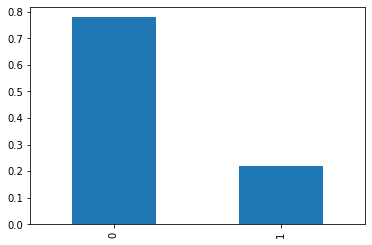

In [54]:
# sanity check
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(label__X_train, y_train) # train the model 
test_predictions = pd.Series(model.predict(label__X_valid))
class_frequency = test_predictions.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');
print()
print('Accuracy score before upsampling: {:.3f}'.format(accuracy_score(y_valid, test_predictions)))

<div class="alert alert-warning">
<b>Reviewer's comment</b>

To check for class imbalance you need to look at train set targets, not predictions of a model.

</div>

As we can see we have a considerable class imbalance betweeen our churned and current customer base. I will use upsampling to balance the classes 

In [55]:
 def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )
    return features_upsampled, target_upsampled

# new training set created
features_upsampled, target_upsampled = upsample(
    label__X_train, y_train, 5
)

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's nice that you tried upsampling!

</div>

0    0.521575
1    0.478425
dtype: float64

Accuracy score after upsampling: 0.735


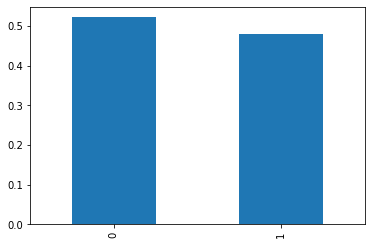

In [56]:
# sanity check after upsampling
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled) # train the model 
test_predictions = pd.Series(model.predict(label__X_valid))
class_frequency = test_predictions.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');
print()
print('Accuracy score after upsampling: {:.3f}'.format(accuracy_score(y_valid, test_predictions)))

our accuracy went down but now our classes are much more balanced. 

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Predictions of the model need not be balanced. Upsampling is applied to help the model better learn about the underrepresented class during training, but if the real data distribution is not balanced, then making balanced predictions will probably produce poor results. So, we really need to look at the metrics (not accuracy, as it poorly reflects performance on imbalanced datasets), not how balanced predictions are.

</div>

In [57]:
# upsampling the other label encoded trainsets
label__X_train_upsampled, y_train_upsampled = upsample(
    label__X_train, y_train, 5
)

X_train_ohe_upsampled, y_train_ohe_upsampled = upsample(
    X_train_ohe, y_train_ohe, 5
)

X_train_upsampled, y_train_upsampled = upsample(
    X_train, y_train, 5
)

### Logistic Regression

In [58]:
%%time
 
grid_logreg = {
    "C": [0.01, 0.1, 1],
    'penalty': ['l2'], 
    'solver': ['lbfgs']
}

# define the model
logreg_clf = LogisticRegression(random_state = 12345)

grid_search_logreg = GridSearchCV(
    estimator = logreg_clf,
    param_grid = grid_logreg,
    scoring = 'roc_auc',
    cv = 10
)

logreg_cv = grid_search_logreg.fit(X_train_ohe, y_train_ohe)

print('The best hyperparameters are: {}'.format(logreg_cv.best_params_))

The best hyperparameters are: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
CPU times: user 1.63 s, sys: 4.21 s, total: 5.84 s
Wall time: 5.8 s


In [59]:
# function to train model and make predictions
def train_logistic_regression_classifier(X_train, y_train):
    """This function trains a logistic regression model"""
    global logreg_model
   
    logreg_model = LogisticRegression(**grid_search_logreg.best_params_)
    logreg_model.fit(X_train, y_train) 
    
def logistic_regression_classifier_prediction(X_valid, y_valid):
    """
    This function is used to make prediction 
    using a logistic regression classification model
    """
    global logreg_pred, logreg_pred_proba
    logreg_pred = logreg_model.predict(X_valid)
    logreg_pred_proba = logreg_model.predict_proba(X_valid)[:, 1]
    # AUC-ROC score
    print("\033[1m" + 'AUC-ROC Score and Accuracy using Logistic Regression Classifier : ' + "\033[0m")
    print('AUC-ROC Score: {:.2%}'.format(roc_auc_score(y_valid, logreg_pred_proba)))
    # accuracy for logistic regression classifier
    logreg_accuracy = accuracy_score(y_valid, logreg_pred)
    print('Accuracy score: {:.2%}'.format(logreg_accuracy))
  

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Do we really need to use global variables here?

</div>

In [60]:
%%time
train_logistic_regression_classifier(X_train_ohe, y_train_ohe)

CPU times: user 97.5 ms, sys: 172 ms, total: 269 ms
Wall time: 293 ms


In [61]:
%%time
logistic_regression_classifier_prediction(X_valid_ohe, y_valid_ohe)

AUC-ROC Score and Accuracy using Logistic Regression Classifier : 
AUC-ROC Score: 88.85%
Accuracy score: 84.63%
CPU times: user 5.3 ms, sys: 30.5 ms, total: 35.8 ms
Wall time: 9.58 ms


Logistic regression is able to score an AUC-ROC of 88%, lets see if we can do better with hyper parameter tuning in other models 

### Random Forest Classifier with hyperparameter tuning 

In [62]:
%%time
grid_rf = {
    "criterion" : ["gini", "entropy"],
    "n_estimators" : [10, 25, 50, 100],
    "max_depth" : [None, 2, 4, 8, 10, 12],
    "min_samples_leaf" : [2, 4, 6]
}
 
rf_clf = RandomForestClassifier(random_state = 12345)

grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid = grid_rf, cv=5, scoring = 'roc_auc')

rf_cv = grid_search_rf.fit(label__X_train, y_train)

print('The best hyperparameters are: {}'.format(rf_cv.best_params_))

The best hyperparameters are: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 50}
CPU times: user 2min 10s, sys: 464 ms, total: 2min 11s
Wall time: 2min 11s


In [63]:
def train_random_forest_classifier(X_train, y_train):
    """This function trains a random forest model"""
    global rf_model
    rf_model = RandomForestClassifier(**grid_search_rf.best_params_)
    rf_model.fit(X_train, y_train) 
    
def random_forest_classifier_prediction(X_valid, y_valid):
    """
    This function is used to make prediction 
    using a random forest classification model
    """
    global rf_pred, rf_pred_proba
    rf_pred = rf_model.predict(X_valid)
    rf_pred_proba = rf_model.predict_proba(X_valid)[:, 1]
    
    print("\033[1m" + 'AUC-ROC Score and Accuracy using Random Forest Classifier' + "\033[0m")
    print('AUC-ROC Score: {:.2%}'.format(roc_auc_score(y_valid, rf_pred_proba)))
    
    rf_accuracy = accuracy_score(y_valid, rf_pred)
    print('Accuracy score: {:.2%}'.format(rf_accuracy))
   

In [64]:
%%time
train_random_forest_classifier(label__X_train, y_train)

CPU times: user 221 ms, sys: 11.9 ms, total: 233 ms
Wall time: 251 ms


In [65]:
%%time
random_forest_classifier_prediction(label__X_valid, y_valid)

AUC-ROC Score and Accuracy using Random Forest Classifier
AUC-ROC Score: 88.33%
Accuracy score: 84.33%
CPU times: user 39.2 ms, sys: 3.96 ms, total: 43.2 ms
Wall time: 40.4 ms


### Catboost Classifier with hyperparameter tuning 


In [66]:
%%time
grid_cb = {'learning_rate': [0.001, 0.01, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
       }
cb_clf = CatBoostClassifier(
    iterations=200,
    cat_features = object_cols,
    logging_level = 'Silent',
    eval_metric='AUC',
    early_stopping_rounds = 50,
    random_state = 12345)

grid_search_cb = GridSearchCV(estimator = cb_clf, param_grid = grid_cb, scoring="roc_auc", cv=5)

cb_cv = grid_search_cb.fit(X_train, y_train)

print('The best hyperparameters are: {}'.format(cb_cv.best_params_))

The best hyperparameters are: {'depth': 4, 'l2_leaf_reg': 7, 'learning_rate': 0.5}
CPU times: user 8min 30s, sys: 4.54 s, total: 8min 34s
Wall time: 8min 54s


In [67]:
def train_catboost_classifier(X_train, y_train, X_valid, y_valid):
    """This function trains a catboost classifier model"""
    global cb_model
    
    cb_model = CatBoostClassifier(**grid_search_cb.best_params_)
    cb_model.fit(X_train, y_train, cat_features = object_cols, eval_set=(X_valid, y_valid), verbose=False, plot=False) # train the model 
    
def catboost_classifier_prediction(X_valid, y_valid):
    """
    This function is used to make prediction 
    using the catboost classifier model
    """
    global cb_pred, cb_pred_proba
    cb_pred = cb_model.predict(X_valid)
    cb_pred_proba = cb_model.predict_proba(X_valid)[:, 1]
   
    print("\033[1m" + 'AUC-ROC Score and Accuracy using CatBoost Classifier' + "\033[0m")
    print('AUC-ROC Score: {:.2%}'.format(roc_auc_score(y_valid, cb_pred_proba)))
   
    cb_accuracy = accuracy_score(y_valid, cb_pred)
    print('Accuracy score: {:.2%}'.format(cb_accuracy))
    

In [68]:
%%time
train_catboost_classifier(X_train, y_train, X_valid, y_valid)

CPU times: user 5.26 s, sys: 63.9 ms, total: 5.33 s
Wall time: 5.49 s


In [69]:
%%time
catboost_classifier_prediction(X_valid, y_valid)

AUC-ROC Score and Accuracy using CatBoost Classifier
AUC-ROC Score: 91.55%
Accuracy score: 86.68%
CPU times: user 21.7 ms, sys: 31 µs, total: 21.7 ms
Wall time: 30.9 ms


AUC-ROC and accuracy are looking much better with this boosted model. Lets try one more.

### LightGBM Classifier

In [70]:
%%time

grid_lgbm = {'learning_rate': [0.05, 0.1],
             'n_estimators': [50, 500],
             'num_leaves': [5, 10]
            }

lgbm_clf = LGBMClassifier(random_state = 12345)

grid_search_lgbm = GridSearchCV(
    estimator = lgbm_clf, 
    param_grid = grid_lgbm, 
    scoring = "accuracy", 
    cv = 5, 
    n_jobs = 1
)

lgbm_cv = grid_search_lgbm.fit(label__X_train, y_train)

print('The best hyperparameters are: {}'.format(lgbm_cv.best_params_))

The best hyperparameters are: {'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 5}
CPU times: user 26 s, sys: 259 ms, total: 26.3 s
Wall time: 26.5 s


In [71]:
def train_lightGBM_classifier(X_train, y_train):
    """This function trains a LightGBM classifier"""
    global lgbm_model
    lgbm_model = LGBMClassifier(**grid_search_lgbm.best_params_)
    lgbm_model.fit(X_train, y_train) 
    
def lightGBM_classifier_prediction(X_valid, y_valid):
    """
    This function is used to make prediction 
    using the LightGBM classifier model
    """
    global lgbm_pred, lgbm_pred_proba
    lgbm_pred = lgbm_model.predict(X_valid)
    lgbm_pred_proba = lgbm_model.predict_proba(X_valid)[:, 1]
    
    print("\033[1m" + 'AUC-ROC Score and Accuracy using LightGBM Classifier' + "\033[0m")
    print('AUC-ROC Score: {:.2%}'.format(roc_auc_score(y_valid, lgbm_pred_proba)))

    lgbm_accuracy = accuracy_score(y_valid, lgbm_pred)
    print('Accuracy score: {:.2%}'.format(lgbm_accuracy))
 

<div class="alert alert-success">
<b>Reviewer's comment</b>

In `*_classifier_prediction()` functions ROC-AUC is calculated correctly

</div>

In [72]:
%%time

train_lightGBM_classifier(label__X_train, y_train)

CPU times: user 594 ms, sys: 7.03 ms, total: 601 ms
Wall time: 590 ms


In [73]:
%%time

lightGBM_classifier_prediction(label__X_valid, y_valid)

AUC-ROC Score and Accuracy using LightGBM Classifier
AUC-ROC Score: 91.04%
Accuracy score: 87.66%
CPU times: user 82 ms, sys: 3.92 ms, total: 85.9 ms
Wall time: 26.5 ms


We can see that lightGBM achieved a AUC-ROC score of 91% and an accuracy score of 87%. Lets move on to chosing our algorithm.  

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you tried a few different models and tuned their hyperparameters using cross-validated grid search

</div>

### Final testing 

In [74]:
# determine best algorithm
models = {'LogisticRegression':logreg_cv.best_score_,
          'RandomForest':rf_cv.best_score_,
          'LightGBM': lgbm_cv.best_score_,
          'CatBoost': cb_cv.best_score_
         }

bestalgorithm = max(models, key=models.get)
print('Best model is', bestalgorithm,'with a score of', models[bestalgorithm])
if bestalgorithm == 'LogisticRegression':
    print('Best params is :', logreg_cv.best_params_)
if bestalgorithm == 'RandomForest':
    print('Best params is :', rf_cv.best_params_)
if bestalgorithm == 'LightGBM':
    print('Best params is :', lgbm_cv.best_params_)
if bestalgorithm == 'CatBoost':
    print('Best params is :', cb_cv.best_params_)

Best model is CatBoost with a score of 0.9053514318211308
Best params is : {'depth': 4, 'l2_leaf_reg': 7, 'learning_rate': 0.5}


### Predictions on the test dataset

In [75]:
%%time
#final test with the test dataset
catboost_classifier_prediction(X_test, y_test)

AUC-ROC Score and Accuracy using CatBoost Classifier
AUC-ROC Score: 90.92%
Accuracy score: 86.83%
CPU times: user 22.8 ms, sys: 45 µs, total: 22.8 ms
Wall time: 19.8 ms


In [76]:
# function to calculate model evaluation metrics
def final_model_evaluation(y_test, test_predictions):
    print("\033[1m" + 'F1 score: ' + "\033[0m", '{:.3f}'.format(f1_score(y_test, test_predictions)))
    print("\033[1m" + 'Accuracy Score: ' + "\033[0m", '{:.2%}'.format(accuracy_score(y_test, test_predictions)))
    print("\033[1m" + 'Precision: ' + "\033[0m", '{:.3f}'.format(precision_score(y_test, test_predictions)))
    print("\033[1m" + 'Recall: ' + "\033[0m", '{:.3f}'.format(recall_score(y_test, test_predictions)))
    print()
    print("\033[1m" + 'Confusion Matrix' + "\033[0m")
    print('-'*50)
    print(confusion_matrix(y_test, test_predictions))
    print()
    print("\033[1m" + 'Classification report' + "\033[0m")
    print('-'*50)
    print(classification_report(y_test, test_predictions))
    print()

final_model_evaluation(y_test, cb_pred)

F1 score:  0.734
Accuracy Score:  86.83%
Precision:  0.804
Recall:  0.675

Confusion Matrix
--------------------------------------------------
[[1209   78]
 [ 154  320]]

Classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1287
           1       0.80      0.68      0.73       474

    accuracy                           0.87      1761
   macro avg       0.85      0.81      0.82      1761
weighted avg       0.86      0.87      0.86      1761




<div class="alert alert-success">
<b>Reviewer's comment</b>

The final model was evaluated on the test set for an unbiased estimate of its generalization performance
    

</div>

## Conclusions

Through exploratry data analysis we were able to learn useful information about customer churn. These insights were: 
- Most customers prefer the month-to- month plan, with a majority of 61% of the customer base chosing this option
- Customers with a 2 year contract are bringing in more revenue than the other two contract options 
- Customers on a 2 year contract are churning less than the other contracts
- customers having 5 or more services with telecom are less likely to churn
Then through machine learning we were able to develop a model which is able to predict customer churn with 87% accuracy and a AUR-ROC score of 90.9. This will be useful to telecom in reducing customer churn by having a tool to predict it.

Action steps for Telecom would be the following:
- incentivize 2 year contract participation, one month free, get two services for the price of one for the first year etc.
- boost multiple service use by using promotions 
- introduce bonuses and incentives before peak churn months
- utilize model to predict customers likelyhood of canceling and use that information to target incentives, reducing the number of promotions distributed and therefore saving the company money
 